<a href="https://colab.research.google.com/github/Jaimemorillo/ShouldIwatchThisMovie/blob/master/Memoria_experiment3_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Aplicamos las técnicas de preprocesamiento que hemos comprobado más efectivas y aplicamos word emmbedding. Al ser el resultado una matriz aplicamos CNN

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [69]:
import pandas as pd
import numpy as np

from tqdm.notebook import tqdm
tqdm.pandas()

from numpy.random import seed
seed(9)

import tensorflow as tf
tf.random.set_seed(9)

import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

import seaborn as sns
sns.set_style("white")
sns.set_context("notebook")

import nltk
from nltk.tokenize import WordPunctTokenizer
import keras
import re
import string
from collections import Counter

nltk.download("popular")
nltk.download('stopwords')
print(tf.__version__)

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Package inaugural is already up-to-date!
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package movie_reviews is already up-to-date!
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Package names is already up-to-date!
[nltk_data]    | Do

/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [4]:
df = pd.read_csv("gdrive/My Drive/TFG/overviews_final.csv", sep='#',encoding='utf-8', lineterminator='\n')

df['text_array'] = df.overview.str.split(" ")
df['n_words'] = df['text_array'].apply(lambda x: len(x))
df = df.drop(columns=['text_array'])
df = df[df['n_words']>15]

df.shape

(1052, 9)

In [5]:
df['new_overviews'] = df['new_overviews'].progress_apply(lambda x: eval(x))

In [7]:
# Normalización

def normalize(x):
  x = x.lower()
  replacements = (
      ("á", "a"),
      ("é", "e"),
      ("í", "i"),
      ("ó", "o"),
      ("ú", "u"),
      ("ñ", "n")
  )
  for a, b in replacements:
      x = x.replace(a, b)

  x = x.translate(str.maketrans('','',string.punctuation))
  x = x.translate(str.maketrans('','','ªº¡¿'))   
  x = x.replace("  ", " ") 
  return x

# Stop_words

stop_words = pd.read_csv("gdrive/My Drive/TFG/stopwords-es.txt",header=None)
stop_words = stop_words[0].tolist()
stop_words = [normalize(word) for word in stop_words]

def delete_stop_words(x):
  words = x.split(' ')
  words = [word for word in words if word not in stop_words]
  x = str(' '.join(words))
  return x

# Steaming

from nltk import word_tokenize
from nltk.stem import SnowballStemmer

stemmer = SnowballStemmer("spanish", ignore_stopwords=True)

def stem_sentence(sentence):
  stemmed_text = [stemmer.stem(word) for word in word_tokenize(sentence)]
  return " ".join(stemmed_text)

In [8]:
df['overview'] = df['overview'].progress_apply(lambda x: normalize(x))
df['new_overviews'] = df['new_overviews'].progress_apply(lambda x: [normalize(i) for i in x])

df['overview'] = df['overview'].progress_apply(lambda x: delete_stop_words(x))
df['new_overviews'] = df['new_overviews'].progress_apply(lambda x: [delete_stop_words(i) for i in x])

df['overview'] = df['overview'].progress_apply(lambda x: stem_sentence(x))
df['new_overviews'] = df['new_overviews'].progress_apply(lambda x: [stem_sentence(i) for i in x])

In [78]:
# Get Text augmentation

X = df.drop(columns=['like'])
y = df['like']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=1996)

X_test = X_test['overview']
y_test = y_test.values

X_train_new = X_train['overview'].copy()
y_train_new = y_train.copy()

for i in range(0, len(X_train)):
  new_series_X = pd.Series(X_train.iloc[i]['new_overviews'])
  X_train_new = X_train_new.append(new_series_X, ignore_index=True)

  y_value = y_train.iloc[i]
  new_series_y = pd.Series([y_value, y_value, y_value])
  y_train_new = y_train_new.append(new_series_y, ignore_index=True)

y_train_new = y_train_new.values

In [79]:
# Parameters
num_words = 6000
maxlen = 90

Como en la practica lo que hace Keras para calcular el embedding es indexar la matriz de embbedding necesitamos asignar un índice a cada palabra y aplicarlo a los textos, vamos a generar este indice en función de las sinopsis del train.

In [80]:
# https://keras.io/api/preprocessing/text/

tokenizer = Tokenizer(num_words=num_words, oov_token='OOV') # Mark non vocabulary words with index 1
tokenizer.fit_on_texts(X_train_new)
print(X_train_new[0]) 

X_train = tokenizer.texts_to_sequences(X_train_new) 
X_test = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1 # Adding 1 because of reserved 0 index for future padding

print(X_train[0]) 
print(vocab_size)

# Max length vector
print(len(max(X_train, key=len)))

print(tokenizer.word_index.items())

futur kaijus logr conquist tierr human deber dej hog mud planet desgraci alberg unic esper sobreviv volv tierr venc godzill regres 20000 anos domini kaiju human deber enfrent
[60, 4388, 155, 665, 19, 13, 54, 53, 215, 577, 46, 1747, 4094, 37, 58, 126, 112, 19, 629, 2106, 66, 1, 4, 1192, 1872, 13, 54, 25]
8943
90
dict_items([('OOV', 1), ('vid', 2), ('mund', 3), ('anos', 4), ('amig', 5), ('jov', 6), ('hij', 7), ('cas', 8), ('padr', 9), ('viv', 10), ('descubr', 11), ('conoc', 12), ('human', 13), ('famili', 14), ('decid', 15), ('histori', 16), ('ayud', 17), ('llam', 18), ('tierr', 19), ('misteri', 20), ('lleg', 21), ('agent', 22), ('hombr', 23), ('peligr', 24), ('enfrent', 25), ('luch', 26), ('nin', 27), ('pas', 28), ('secret', 29), ('grup', 30), ('form', 31), ('acab', 32), ('pequen', 33), ('poder', 34), ('encontr', 35), ('chic', 36), ('unic', 37), ('ciud', 38), ('salv', 39), ('muert', 40), ('aventur', 41), ('mision', 42), ('herman', 43), ('busc', 44), ('viaj', 45), ('planet', 46), ('equip'

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


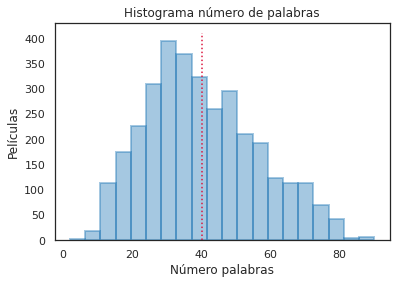

In [83]:
n_words_train = np.array([len(i) for i in X_train])

# seaborn histogram
sns.distplot(n_words_train, hist=True, kde=False, 
             bins=20,
             hist_kws={'edgecolor':'tab:blue', 'linewidth': 2})
# Add labels
plt.title('Histograma número de palabras')
plt.xlabel('Número palabras')
plt.ylabel('Películas')

mean = n_words_train.mean()
plt.vlines(mean, 0, 410, color='crimson', ls=':')

In [70]:
X_train = pad_sequences(X_train, padding='pre', maxlen=maxlen, truncating='post')
X_test = pad_sequences(X_test, padding='pre', maxlen=maxlen, truncating='post')

X_train[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   60, 4388,  155,  665,
         19,   13,   54,   53,  215,  577,   46, 1747, 4094,   37,   58,
        126,  112,   19,  629, 2106,   66,    1,    4, 1192, 1872,   13,
         54,   25], dtype=int32)